## Transit Simulation
* Author: Callie Clark (last updated 6/6/2024)
* Code created with Dr. Elif's Ansari's code as reference and Urban Access plugin's demo example on https://github.com/UDST/urbanaccess by Paul Waddell and Sam Blanchard


In [1]:
import matplotlib
import pandas as pd
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import pandana as pdna
import time

import urbanaccess as ua
from urbanaccess.config import settings
from urbanaccess.gtfsfeeds import feeds
from urbanaccess import gtfsfeeds
from urbanaccess.gtfs.gtfsfeeds_dataframe import gtfsfeeds_dfs
from urbanaccess.network import ua_network, load_network

import geopandas as gpd
import numpy as np
from scipy.spatial import cKDTree

from TT_functions import *

%matplotlib inline

In [2]:
def nearest_k_fp_list(t_period,fp_df,CT_gpd,k):
    
    open_fp_dict=get_time_table_id(fp_df)
    fp_df_open=fp_df.loc[open_fp_dict[t_period],:] #pass in index as nodes 
    k_val= min(k,len(open_fp_dict[t_period]))
    idx_nearest=ckdnearest(CT_gpd,fp_df_open, k_val)
    
    fp_node_lists=[[] for i in range(k_val)]
    fp_id_lists=[[] for i in range(k_val)]

    #loop through CTS
    for i in range(len(idx_nearest)):
        # if len(fp_df_open.iloc[idx_nearest[i]].index)<k_val:
        #         print('error!')

        #add node to list
        count=0
        for j in fp_df_open.iloc[idx_nearest[i]].index:
            fp_node_lists[count].append(j) 
            count+=1
        
        #add name of fp to list
        count=0
        for m in fp_df_open.iloc[idx_nearest[i]].id:
            fp_id_lists[count].append(m)
            count+=1
            

    return fp_node_lists, fp_id_lists
        
    

In [3]:
settings.to_dict()

{'data_folder': 'data',
 'logs_folder': 'logs',
 'log_file': True,
 'log_console': False,
 'log_name': 'urbanaccess',
 'log_filename': 'urbanaccess',
 'txt_encoding': 'utf-8',
 'gtfs_api': {'gtfsdataexch': 'http://www.gtfs-data-exchange.com/api/agencies?format=csv'}}

## Load Census Tract and Food Pantry Data

In [4]:
ct_coords=pd.read_csv('geo_files/census_tract_centroid.csv',index_col=0)

fp_df=gpd.read_file('FP_data/food_pantry_schedule_final.geojson',index_col=0)


## Download NYC GTFS Feeds and make network

In [5]:
feeds.to_dict()

{'gtfs_feeds': {}}

In [6]:
#add NYC transit feeds
feeds.add_feed(add_dict={'nyc transit0': 'http://web.mta.info/developers/data/busco/google_transit.zip'}) #mta bus company
feeds.add_feed(add_dict={'nyc transit1': 'http://web.mta.info/developers/data/nyct/subway/google_transit.zip'}) #subway
feeds.add_feed(add_dict={'nyc transit2': 'http://web.mta.info/developers/data/nyct/bus/google_transit_manhattan.zip'}) #manhattan bus
feeds.add_feed(add_dict={'nyc transit3': 'http://web.mta.info/developers/data/nyct/bus/google_transit_brooklyn.zip'}) #brooklyn bus
feeds.add_feed(add_dict={'nyc transit4': 'http://web.mta.info/developers/data/nyct/bus/google_transit_queens.zip'})#queens bus
feeds.add_feed(add_dict={'nyc transit5': 'http://web.mta.info/developers/data/nyct/bus/google_transit_bronx.zip'}) #bronx bus
feeds.add_feed(add_dict={'nyc transit6': 'http://web.mta.info/developers/data/nyct/bus/google_transit_staten_island.zip'}) #staten island bus

Added 1 feeds to gtfs_feeds: {'nyc transit0': 'http://web.mta.info/developers/data/busco/google_transit.zip'}
Added 1 feeds to gtfs_feeds: {'nyc transit1': 'http://web.mta.info/developers/data/nyct/subway/google_transit.zip'}
Added 1 feeds to gtfs_feeds: {'nyc transit2': 'http://web.mta.info/developers/data/nyct/bus/google_transit_manhattan.zip'}
Added 1 feeds to gtfs_feeds: {'nyc transit3': 'http://web.mta.info/developers/data/nyct/bus/google_transit_brooklyn.zip'}
Added 1 feeds to gtfs_feeds: {'nyc transit4': 'http://web.mta.info/developers/data/nyct/bus/google_transit_queens.zip'}
Added 1 feeds to gtfs_feeds: {'nyc transit5': 'http://web.mta.info/developers/data/nyct/bus/google_transit_bronx.zip'}
Added 1 feeds to gtfs_feeds: {'nyc transit6': 'http://web.mta.info/developers/data/nyct/bus/google_transit_staten_island.zip'}


In [7]:
feeds.to_dict()

{'gtfs_feeds': {'nyc transit0': 'http://web.mta.info/developers/data/busco/google_transit.zip',
  'nyc transit1': 'http://web.mta.info/developers/data/nyct/subway/google_transit.zip',
  'nyc transit2': 'http://web.mta.info/developers/data/nyct/bus/google_transit_manhattan.zip',
  'nyc transit3': 'http://web.mta.info/developers/data/nyct/bus/google_transit_brooklyn.zip',
  'nyc transit4': 'http://web.mta.info/developers/data/nyct/bus/google_transit_queens.zip',
  'nyc transit5': 'http://web.mta.info/developers/data/nyct/bus/google_transit_bronx.zip',
  'nyc transit6': 'http://web.mta.info/developers/data/nyct/bus/google_transit_staten_island.zip'}}

In [8]:
#make sure that the jupyter notebook directory doesn't have log and data files from earlier runs
gtfsfeeds.download()

7 GTFS feed(s) will be downloaded here: data/gtfsfeed_zips
nyc transit0 GTFS feed downloaded successfully. Took 0.49 seconds for 10,186,024.0KB
nyc transit1 GTFS feed downloaded successfully. Took 0.27 seconds for 5,636,204.0KB
nyc transit2 GTFS feed downloaded successfully. Took 0.47 seconds for 7,850,387.0KB
nyc transit3 GTFS feed downloaded successfully. Took 2.95 seconds for 16,670,405.0KB
nyc transit4 GTFS feed downloaded successfully. Took 0.55 seconds for 8,387,113.0KB
nyc transit5 GTFS feed downloaded successfully. Took 0.29 seconds for 7,797,078.0KB
nyc transit6 GTFS feed downloaded successfully. Took 0.38 seconds for 6,144,343.0KB
GTFS feed download completed. Took 5.41 seconds
nyc transit0.zip successfully extracted to: data/gtfsfeed_text/nyc transit0
nyc transit1.zip successfully extracted to: data/gtfsfeed_text/nyc transit1
nyc transit2.zip successfully extracted to: data/gtfsfeed_text/nyc transit2
nyc transit3.zip successfully extracted to: data/gtfsfeed_text/nyc transit3

In [9]:
validation = True
verbose = True
# bbox for NYC
bbox = (-74.2591, 40.4774, -73.7004, 40.9153) ## analysis area bounding box
remove_stops_outsidebbox = True
append_definitions = True

loaded_feeds = ua.gtfs.load.gtfsfeed_to_df(gtfsfeed_path=None,
                                           validation=validation,
                                           verbose=verbose,
                                           bbox=bbox,
                                           remove_stops_outsidebbox=remove_stops_outsidebbox,
                                           append_definitions=append_definitions)

Checking GTFS text file header whitespace... Reading files using encoding: utf-8 set in configuration.
GTFS text file header whitespace check completed. Took 2.88 seconds
--------------------------------
Processing GTFS feed: nyc transit0
The unique agency id: mta_bus_company was generated using the name of the agency in the agency.txt file.
Unique agency id operation complete. Took 0.06 seconds
Unique GTFS feed id operation complete. Took 0.01 seconds
Records:
     stop_id                stop_name                  stop_desc   stop_lat  \
3543  985001    S BROADWAY/RADFORD ST    S BROADWAY & RADFORD ST  40.917649   
3544  985002     S BROADWAY/McLEAN AV     S BROADWAY & McLEAN AV  40.920954   
3545  985003  S BROADWAY/PARK HILL AV  S BROADWAY & PARK HILL AV  40.929116   
3546  985004   S BROADWAY/PROSPECT AV   S BROADWAY & PROSPECT AV  40.931539   
3547  985005   S BROADWAY/NEW MAIN ST   S BROADWAY & NEW MAIN ST  40.933637   
3548  985006   S BROADWAY/PROSPECT ST   S BROADWAY & PROSPEC

## Download OSM Data

In [10]:
nodes, edges = ua.osm.load.ua_network_from_bbox(bbox=bbox,
                                                remove_lcn=True)
ua.osm.network.create_osm_net(osm_edges=edges,
                              osm_nodes=nodes,
                              travel_speed_mph=2.8) #equivalent to 4.5kmh as used in sim



Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](40.47740000,-74.25910000,40.91530000,-73.70040000);>;);out;'}"
Downloaded 289,315.2KB from www.overpass-api.de in 12.22 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 27.96 seconds
Returning OSM data with 1,530,405 nodes and 470,689 ways...
Edge node pairs completed. Took 825.57 seconds
Returning processed graph with 692,980 nodes and 2,073,548 edges...
Completed OSM data download and Pandana node and edge table creation in 902.03 seconds
checking for low connectivity nodes...
Generating contraction hierarchies with 64 threads.
Setting CH node vector of size 692980
Setting CH edge vector of size 2115828
Range graph removed 2179012 edges of 

## Construct GTFS NEtwork by TOD

In [11]:
t_periods={'Mo_period_2':['monday',['11:00:00', '13:00:00']], 'Mo_period_3':['monday',['15:00:00', '17:00:00']], 'Mo_period_4':['monday',['19:00:00', '21:00:00']], 
 'Tu_period_1':['tuesday',['07:00:00', '09:00:00']], 'Tu_period_2':['tuesday',['11:00:00', '13:00:00']], 'Tu_period_3':['tuesday',['15:00:00', '17:00:00']], 'Tu_period_4':['tuesday',['19:00:00', '21:00:00']], 
 'We_period_1':['wednesday',['07:00:00', '09:00:00']], 'We_period_2':['wednesday',['11:00:00', '13:00:00']], 'We_period_3':['wednesday',['15:00:00', '17:00:00']], 'We_period_4':['wednesday',['19:00:00', '21:00:00']], 
 'Th_period_1':['thursday',['07:00:00', '09:00:00']], 'Th_period_2':['thursday',['11:00:00', '13:00:00']], 'Th_period_3':['thursday',['15:00:00', '17:00:00']], 'Th_period_4':['thursday',['19:00:00', '21:00:00']], 
 'Fr_period_1':['friday',['07:00:00', '09:00:00']], 'Fr_period_2':['friday',['11:00:00', '13:00:00']], 'Fr_period_3':['friday',['15:00:00', '17:00:00']], 'Fr_period_4':['friday',['19:00:00', '21:00:00']], 
 'Sa_period_1':['saturday',['07:00:00', '09:00:00']], 'Sa_period_2':['saturday',['11:00:00', '13:00:00']], 'Sa_period_3':['saturday',['15:00:00', '17:00:00']], 'Sa_period_4':['saturday',['19:00:00', '21:00:00']], 
 'Su_period_1':['sunday',['07:00:00', '09:00:00']], 'Su_period_2':['sunday',['11:00:00', '13:00:00']], 'Su_period_3':['sunday',['15:00:00', '17:00:00']], 'Su_period_4':['sunday',['19:00:00', '21:00:00']]}


In [ ]:

for t_period in t_periods.keys():
    s_time = time.time()
    dow=t_periods[t_period][0]
    hod=t_periods[t_period][1]
    print(dow,hod)
    
    #read in transit network from file if already created, if not create file
#     try:
#         urbanaccess_net = ua.network.load_network(filename='transit_network_files/'+t_period+'_network_UA.h5')
        

    #iterate through all 28 time periods here 
    ua.gtfs.network.create_transit_net(gtfsfeeds_dfs=loaded_feeds,
                                   day=dow,
                                   timerange=hod,
                                   calendar_dates_lookup=None)
    urbanaccess_net = ua.network.ua_network


    print('\nCalculating Headways')
    ua.gtfs.headways.headways(gtfsfeeds_df=loaded_feeds,
                          headway_timerange=hod) 

    #integrate transit and walking networks 
    print('\nintegrating networks')
    ua.network.integrate_network(urbanaccess_network=urbanaccess_net,
                             headways=True,
                             urbanaccess_gtfsfeeds_df=loaded_feeds,
                             headway_statistic='mean')

    # #save network to disk
    # print('saving combined network')
    # ua.network.save_network(urbanaccess_network=urbanaccess_net,
    #                     filename='/transit_network_files/'+t_period+'_network_UA.h5',
    #                     overwrite_key = True)

    print('Creating Pandana Network')
    #create Pandana network
    transit_ped_net = pdna.Network(urbanaccess_net.net_nodes["x"],
                                   urbanaccess_net.net_nodes["y"],
                                   urbanaccess_net.net_edges["from_int"],
                                   urbanaccess_net.net_edges["to_int"],
                                   urbanaccess_net.net_edges[["weight"]], 
                                   twoway=False)

    #get network node data for lat/lon
    
    fp_nodes=transit_ped_net.get_node_ids(fp_df.lng.values,fp_df.lat.values).values
    fp_df['node']=fp_nodes
    fp_df.set_index('node',inplace=True)


    print('\nCalculating Travel Times')

    for k_ in [10,25,50]:
        CT_gpd = gpd.GeoDataFrame(
        ct_coords, geometry=gpd.points_from_xy(ct_coords.lon, ct_coords.lat))
        CT_nodes=transit_ped_net.get_node_ids(CT_gpd.lon.values,CT_gpd.lat.values).values
        CT_gpd['node']=CT_nodes
        CT_gpd.set_index('node',inplace=True)

        #run shortest path for nearest FPs
        fp_node_lists,fp_id_lists=nearest_k_fp_list(t_period,fp_df,CT_gpd,k=k_)

        for iter_i in range(len(fp_node_lists)):
            CT_gpd['tt_'+str(iter_i)]=transit_ped_net.shortest_path_lengths(CT_gpd.index.values,fp_node_lists[iter_i])
            CT_gpd['fp_'+str(iter_i)]=fp_id_lists[iter_i]

        #send to csv
        CT_gpd.set_index('GEOID').to_csv('travel_time_df/transit_dfs/'+t_period+'_tt_'+str(k_)+'.csv')

    print('Took {:,.2f} seconds'.format(time.time() - s_time))



monday ['11:00:00', '13:00:00']
Using calendar to extract service_ids to select trips.
41 service_ids were extracted from calendar
75,378 trip(s) 38.27 percent of 196,966 total trip records were found in calendar for GTFS feed(s): ['nyc transit0', 'nyc transit1', 'nyc transit2', 'nyc transit3', 'nyc transit4', 'nyc transit5', 'nyc transit6']
NOTE: If you expected more trips to have been extracted and your GTFS feed(s) have a calendar_dates file, consider utilizing the calendar_dates_lookup parameter in order to add additional trips based on information inside of calendar_dates. This should only be done if you know the corresponding GTFS feed is using calendar_dates instead of calendar to specify service_ids. When in doubt do not use the calendar_dates_lookup parameter.
75,378 of 196,966 total trips were extracted representing calendar day: monday. Took 0.36 seconds
There are no departure time records missing from trips following the specified schedule. There are no records to interpola

AttributeError: 'list' object has no attribute 'plot'

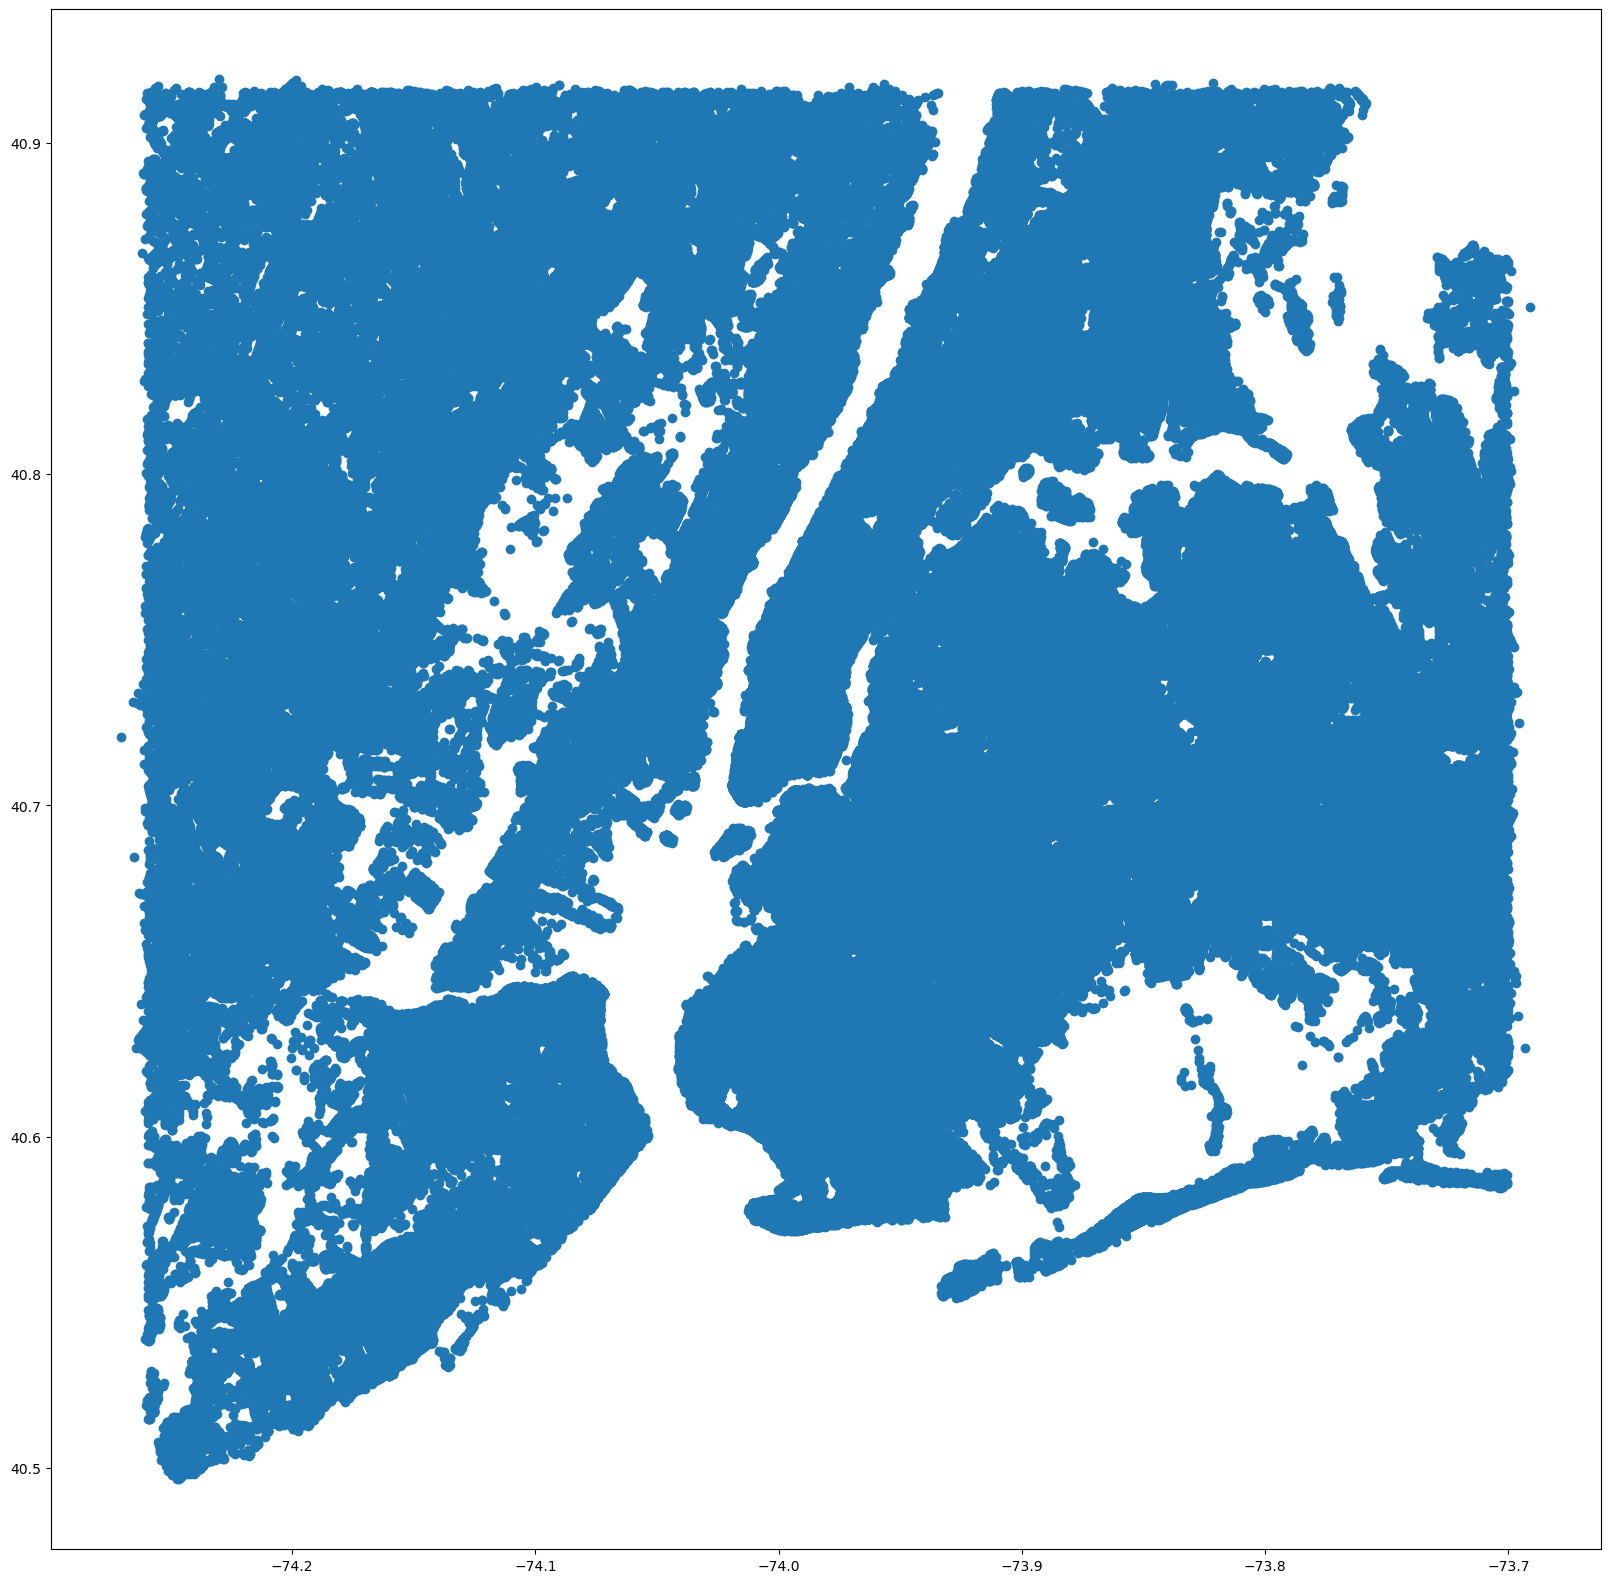

In [74]:
#transit_ped_net.shortest_path_lengths([164514],[188676])

# fig = plt.subplots(figsize=(20,20))

# # data_crs = ccrs.PlateCarree()
# # ax = plt.axes(projection=ccrs.epsg(26943))
# #ax.add_feature(cartopy.feature.GSHHSFeature(scale='full'), edgecolor='grey')
# nodes_path=transit_ped_net.shortest_paths([164514],[188676])
# plt.scatter(transit_ped_net.nodes_df.x, transit_ped_net.nodes_df.y)
# transit_ped_net.shortest_paths([164514],[188676]).plot()
# #transit_ped_net.plot(nodes_path)
# #cb = plt.colorbar()


## Combine Dataframe
* Don't need to run any code above (except import to run this)

In [24]:
# load in dfs needed 
ct_coords=pd.read_csv('geo_files/census_tract_centroid.csv',index_col=0)

fp_df=gpd.read_file('FP_data/food_pantry_schedule_final.geojson',index_col=0)

CT_gpd = gpd.GeoDataFrame(
    ct_coords, geometry=gpd.points_from_xy(ct_coords.lon, ct_coords.lat))

open_fp_dict=get_time_table_id(fp_df)
open_fp_dict.keys()



dict_keys(['Mo_period_1', 'Mo_period_2', 'Mo_period_3', 'Mo_period_4', 'Tu_period_1', 'Tu_period_2', 'Tu_period_3', 'Tu_period_4', 'We_period_1', 'We_period_2', 'We_period_3', 'We_period_4', 'Th_period_1', 'Th_period_2', 'Th_period_3', 'Th_period_4', 'Fr_period_1', 'Fr_period_2', 'Fr_period_3', 'Fr_period_4', 'Sa_period_1', 'Sa_period_2', 'Sa_period_3', 'Sa_period_4', 'Su_period_1', 'Su_period_2', 'Su_period_3', 'Su_period_4'])

In [25]:
fp_df[fp_df.id=='85540']#[['Hours FINAL', 'Hours FPC','Mo_open', 'Mo_close']]

,id,Name,Address,Hours FINAL,Hours FPC,Hours Plentiful,lat,lng,Additional Notes,BoroName,...,Th_close,Fr_open,Fr_close,Sa_open,Sa_close,Su_open,Su_close,Hours_parsed,hours_open,geometry
178,85540,LifeBridge NY,1895 Flatbush Ave,We 05:00PM-07:00PM,We 05:00PM-07:00PM,NaT,40.623694,-73.937544,- Open to the public. \n- Please bring your ow...,Brooklyn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,POINT (-73.93754 40.62369)


In [39]:
fp_df[fp_df.id=='84206']#[['Hours FINAL', 'Hours FPC','Mo_open', 'Mo_close']]

,id,Name,Address,Hours FINAL,Hours FPC,Hours Plentiful,lat,lng,Additional Notes,BoroName,...,Th_close,Fr_open,Fr_close,Sa_open,Sa_close,Su_open,Su_close,Hours_parsed,hours_open,geometry
431,84206,Sephardic Bikur Holim Food Pantry,425 Kings Hwy,"mo,tu,we,th 09:00AM-04:30PM","mo,tu,we,th 09:00AM-04:30PM",NaT,40.604699,-73.97483,- Food available by appointment only\n,Brooklyn,...,16.5,NaN,NaN,NaN,NaN,NaN,NaN,1.0,30.0,POINT (-73.97483 40.60470)


In [33]:
df_tt = pd.DataFrame(index=CT_gpd.GEOID)# creates df with Geoid as index
k=50
for i in open_fp_dict.keys():
#for i in col_list:
    df_=pd.read_csv('travel_time_df/transit_dfs/'+i+'_tt_'+str(k)+'.csv')
    
    #find nearest FP 
    df_['nearest_fp_']=df_.loc[:,[i for i in df_.columns if 'tt' in i]].T.idxmin().str.replace('tt','fp')
    
    nearest_fp=[]
    for j in df_.index:
        nearest_fp.append(df_.loc[df_.index[j],df_.loc[df_.index[j],'nearest_fp_']])
    df_tt[i+'_nearest']=nearest_fp
    df_.drop(columns=['nearest_fp_'],inplace=True)
    
    #assign shortest tt
    df_tt[i+'_tt']=list(df_.loc[:,[i for i in df_.columns if 'tt' in i]].min(axis=1).values.round(2))
    
    #assign average of 3 shortest tt
    top_3=[]
    df_t=df_.loc[:,[i for i in df_.columns if 'tt' in i]].T
    for j in df_t.columns:
        top_3.append(round(df_t[[j]].sort_values(by=j).head(n=3).mean().values[0],2))
    df_tt[i+'_tt_3']=top_3
df_tt.to_csv('travel_time_df/df_tt_transit_k'+str(k)+'_.csv')

In [64]:
i='We_period_4'
df_=pd.read_csv('travel_time_df/transit_dfs/'+i+'_tt_25.csv')
df_

,GEOID,BoroName,NTA2020,lon,lat,centroid,geometry,tt_0,fp_0,tt_1,...,tt_20,fp_20,tt_21,fp_21,tt_22,fp_22,tt_23,fp_23,tt_24,fp_24
0,36061000100,Manhattan,MN0191,-74.042340,40.695673,POINT (-74.04233991488555 40.69567298240604),POINT (-74.04233963651815 40.69567322688057),171.468,85517,160.368,...,213.035,FPC-601,212.998,85357,217.326,85251,220.794,87064,222.055,85108
1,36061000201,Manhattan,MN0301,-73.985848,40.711869,POINT (-73.98584800028144 40.71186871871548),POINT (-73.98584800829613 40.71186874601334),12.063,85434,17.654,...,58.209,85251,53.870,85357,64.625,87064,46.414,83916,65.712,85108
2,36061000600,Manhattan,MN0301,-73.989477,40.711951,POINT (-73.9894767752886 40.711950582311424),POINT (-73.989476789607 40.71195059941946),15.368,85434,21.278,...,53.493,85251,51.276,83916,49.154,85357,62.095,87064,60.996,85108
3,36061001401,Manhattan,MN0302,-73.987332,40.715160,POINT (-73.98733213277733 40.715160475095416),POINT (-73.98733213729894 40.71516046573841),10.399,85434,23.392,...,54.734,85251,50.395,85357,63.066,87064,52.516,83916,62.237,85108
4,36061001402,Manhattan,MN0302,-73.985882,40.717513,POINT (-73.98588163638996 40.71751329107455),POINT (-73.9858816314248 40.71751329862137),6.619,85434,19.823,...,52.772,85251,47.777,85357,61.326,87064,59.619,85108,52.400,83916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,36047066600,Brooklyn,BK1891,-73.916235,40.594024,POINT (-73.91623335169032 40.59402388288404),POINT (-73.91623533226617 40.59402430076491),27.193,85540,37.548,...,115.172,85071,83.539,FPC-624,116.054,85314,119.801,85221,77.981,83916
2321,36061002400,Manhattan,MN0303,-73.973678,40.723954,POINT (-73.97367781587977 40.72395420113046),POINT (-73.97367781343603 40.72395422711615),13.145,85434,24.397,...,56.482,87064,64.503,85251,51.572,85357,57.848,85108,52.983,83916
2322,36047055500,Brooklyn,BK0102,-73.963275,40.718096,POINT (-73.96327467519758 40.718095748390894),POINT (-73.96327466194677 40.71809576144238),27.587,85434,27.159,...,55.195,85251,62.749,87064,56.326,85357,64.115,85108,65.681,83916
2323,36047017700,Brooklyn,BK5591,-73.968921,40.661600,POINT (-73.96892143815543 40.66159963184397),POINT (-73.96892138267501 40.66160007808906),24.510,FPC-488,35.969,...,68.038,82750,57.239,83916,82.121,FPC-690,82.217,87064,74.527,85357


In [68]:
df_[df_.GEOID==36061007001]

,GEOID,BoroName,NTA2020,lon,lat,centroid,geometry,tt_0,fp_0,tt_1,...,tt_20,fp_20,tt_21,fp_21,tt_22,fp_22,tt_23,fp_23,tt_24,fp_24
33,36061007001,Manhattan,MN0603,-73.975824,40.742708,POINT (-73.97582433797677 40.742708355759014),POINT (-73.97582432610801 40.74270836386233),4294967.295,85521,4294967.295,...,4294967.295,87064,4294967.295,85108,4294967.295,80343,4294967.295,85251,4294967.295,83916


In [76]:
fp_df[fp_df.id=='85521']

,id,Name,Address,Hours FINAL,Hours FPC,Hours Plentiful,lat,lng,Additional Notes,BoroName,...,Th_close,Fr_open,Fr_close,Sa_open,Sa_close,Su_open,Su_close,Hours_parsed,hours_open,geometry
818,85521,"Mercy College, Mav Market Manhattan",47 W 34th St,"mo,tu,we,th,fr 09:00AM–08:00PM","mo,tu,we,th,fr 09:00AM-08:00PM",NaT,40.749758,-73.987189,"- Open to Mercy students, faculty, and staff...",Manhattan,...,20.0,9.0,20.0,NaN,NaN,NaN,NaN,NaN,55.0,POINT (-73.98719 40.74976)


In [78]:
CT_nodes=transit_ped_net.get_node_ids(CT_gpd[CT_gpd.GEOID==36061007001].lon.values,CT_gpd[CT_gpd.GEOID==36061007001].lat.values).values
FP_nodes=transit_ped_net.get_node_ids(fp_df[fp_df.id=='85521'].lng.values,fp_df[fp_df.id=='85521'].lat.values).values

In [85]:
fp_df[fp_df.id=='85521'].lat.values 40.7497577 -73.987189

array([40.7497577])

In [83]:
print(CT_gpd[CT_gpd.GEOID==36061007001].lon.values,CT_gpd[CT_gpd.GEOID==36061007001].lat.values)

[-73.97582433] [40.74270836]


In [82]:
transit_ped_net.shortest_paths(CT_nodes,FP_nodes)

[array([], dtype=int64)]

In [20]:
df_tt = pd.DataFrame(index=CT_gpd.GEOID)
i='We_period_4'
df_=pd.read_csv('travel_time_df/transit_dfs/'+i+'_tt_25.csv')
    
#find nearest FP 
df_['nearest_fp_']=df_.loc[:,[i for i in df_.columns if 'tt' in i]].T.idxmin().str.replace('tt','fp')

nearest_fp=[]
for j in df_.index:
    nearest_fp.append(df_.loc[df_.index[j],df_.loc[df_.index[j],'nearest_fp_']])
df_tt[i+'_nearest']=nearest_fp
df_.drop(columns=['nearest_fp_'],inplace=True)

#assign shortest tt
df_tt[i+'_tt']=list(df_.loc[:,[i for i in df_.columns if 'tt' in i]].min(axis=1).values.round(2))

#assign average of 3 shortest tt
top_3=[]
df_t=df_.loc[:,[i for i in df_.columns if 'tt' in i]].T
for j in df_t.columns:
    top_3.append(round(df_t[[j]].sort_values(by=j).head(n=3).mean().values[0],2))
df_tt[i+'_tt_3']=top_3


In [88]:
df_tt.replace(4294967.3,60)

,Mo_period_1_nearest,Mo_period_1_tt,Mo_period_1_tt_3,Mo_period_2_nearest,Mo_period_2_tt,Mo_period_2_tt_3,Mo_period_3_nearest,Mo_period_3_tt,Mo_period_3_tt_3,Mo_period_4_nearest,...,Su_period_1_tt_3,Su_period_2_nearest,Su_period_2_tt,Su_period_2_tt_3,Su_period_3_nearest,Su_period_3_tt,Su_period_3_tt_3,Su_period_4_nearest,Su_period_4_tt,Su_period_4_tt_3
GEOID,,,,,,,,,,,,,,,,,,,,,
36061007001,85544,60.0,60.0,85490,60.0,60.0,85490,60.0,60.0,85521,...,60.0,82798,60.0,60.0,81735,60.0,60.0,81199,60.0,60.0
36005001904,84728,60.0,60.0,84728,60.0,60.0,84728,60.0,60.0,FPC-624,...,60.0,FPC-493,60.0,60.0,FPC-624,60.0,60.0,FPC-624,60.0,60.0
36005051602,FPC-666,60.0,60.0,FPC-666,60.0,60.0,FPC-666,60.0,60.0,85503,...,60.0,81145,60.0,60.0,85456,60.0,60.0,FPC-624,60.0,60.0
36081045500,84603,60.0,60.0,DSNY-BRS-1033,60.0,60.0,84603,60.0,60.0,82186,...,60.0,DSNY-BRS-1033,60.0,60.0,FPC-493,60.0,60.0,FPC-624,60.0,60.0


In [46]:
df_2=pd.read_csv('travel_time_df/transit_dfs/We_period_4_tt_25.csv')
df_2.head()

,GEOID,BoroName,NTA2020,lon,lat,centroid,geometry,tt_0,fp_0,tt_1,...,tt_20,fp_20,tt_21,fp_21,tt_22,fp_22,tt_23,fp_23,tt_24,fp_24
0,36061000100,Manhattan,MN0191,-74.042340,40.695673,POINT (-74.04233991488555 40.69567298240604),POINT (-74.04233963651815 40.69567322688057),171.468,85517,160.368,...,213.035,FPC-601,212.998,85357,217.326,85251,220.794,87064,222.055,85108
1,36061000201,Manhattan,MN0301,-73.985848,40.711869,POINT (-73.98584800028144 40.71186871871548),POINT (-73.98584800829613 40.71186874601334),12.063,85434,17.654,...,58.209,85251,53.870,85357,64.625,87064,46.414,83916,65.712,85108
2,36061000600,Manhattan,MN0301,-73.989477,40.711951,POINT (-73.9894767752886 40.711950582311424),POINT (-73.989476789607 40.71195059941946),15.368,85434,21.278,...,53.493,85251,51.276,83916,49.154,85357,62.095,87064,60.996,85108
3,36061001401,Manhattan,MN0302,-73.987332,40.715160,POINT (-73.98733213277733 40.715160475095416),POINT (-73.98733213729894 40.71516046573841),10.399,85434,23.392,...,54.734,85251,50.395,85357,63.066,87064,52.516,83916,62.237,85108
4,36061001402,Manhattan,MN0302,-73.985882,40.717513,POINT (-73.98588163638996 40.71751329107455),POINT (-73.9858816314248 40.71751329862137),6.619,85434,19.823,...,52.772,85251,47.777,85357,61.326,87064,59.619,85108,52.400,83916


In [47]:
df_1=pd.read_csv('travel_time_df/transit_dfs_archived/We_period_4_tt_25.csv')
df_1.head()

,GEOID,BoroName,NTA2020,lon,lat,centroid,geometry,tt_0,fp_0,tt_1,...,tt_20,fp_20,tt_21,fp_21,tt_22,fp_22,tt_23,fp_23,tt_24,fp_24
0,36061000100,Manhattan,MN0191,-74.042340,40.695673,POINT (-74.04233991488555 40.69567298240604),POINT (-74.04233963651815 40.69567322688057),171.468,85517,160.368,...,213.035,FPC-601,212.998,85357,217.326,85251,220.794,87064,222.055,85108
1,36061000201,Manhattan,MN0301,-73.985848,40.711869,POINT (-73.98584800028144 40.71186871871548),POINT (-73.98584800829613 40.71186874601334),12.063,85434,17.654,...,58.209,85251,53.870,85357,64.625,87064,46.414,83916,65.712,85108
2,36061000600,Manhattan,MN0301,-73.989477,40.711951,POINT (-73.9894767752886 40.711950582311424),POINT (-73.989476789607 40.71195059941946),15.368,85434,21.278,...,53.493,85251,51.276,83916,49.154,85357,62.095,87064,60.996,85108
3,36061001401,Manhattan,MN0302,-73.987332,40.715160,POINT (-73.98733213277733 40.715160475095416),POINT (-73.98733213729894 40.71516046573841),10.399,85434,23.392,...,54.734,85251,50.395,85357,63.066,87064,52.516,83916,62.237,85108
4,36061001402,Manhattan,MN0302,-73.985882,40.717513,POINT (-73.98588163638996 40.71751329107455),POINT (-73.9858816314248 40.71751329862137),6.619,85434,19.823,...,52.772,85251,47.777,85357,61.326,87064,59.619,85108,52.400,83916


In [55]:
import scipy.stats
corr,p=scipy.stats.pearsonr(df_1['tt_0'],df_2['tt_0'])
print(corr,p)

0.9999999999986366 0.0


In [62]:
df_1[df_1['tt_0']!=df_2['tt_0']]

,GEOID,BoroName,NTA2020,lon,lat,centroid,geometry,tt_0,fp_0,tt_1,...,tt_20,fp_20,tt_21,fp_21,tt_22,fp_22,tt_23,fp_23,tt_24,fp_24
41,36061007800,Manhattan,MN0603,-73.974674,40.746325,POINT (-73.97467365469602 40.746325367646286),POINT (-73.97467365973009 40.74632537305917),13.427,81199,12.634,...,51.096,87064,52.463,85108,61.515,80343,48.390,85251,51.659,83916
127,36061018700,Manhattan,MN0703,-73.972008,40.798091,POINT (-73.97200784280544 40.798091326752164),POINT (-73.97200788311616 40.79809132488262),27.118,FPC-624,30.124,...,68.829,85328,63.448,85307,62.407,85251,69.861,85540,77.969,80343
135,36061020500,Manhattan,MN0901,-73.965123,40.810250,POINT (-73.96512285827792 40.81024951753743),POINT (-73.96512283065759 40.8102495443629),22.213,FPC-624,31.156,...,71.126,85328,53.058,FPC-457,63.873,85251,73.627,85540,81.211,80343
138,36061020800,Manhattan,MN1002,-73.942008,40.809649,POINT (-73.94200774733264 40.809648556316155),POINT (-73.94200773817532 40.80964856059429),13.792,FPC-624,19.268,...,70.794,85328,64.596,85251,52.880,FPC-457,74.451,85540,69.034,FPC-690
150,36061022500,Manhattan,MN0903,-73.954159,40.823834,POINT (-73.95415924560359 40.82383400221907),POINT (-73.95415930352314 40.82383399379226),25.048,FPC-624,33.081,...,74.213,85328,66.960,85251,56.145,FPC-457,76.714,85540,71.398,FPC-690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2144,36061008601,Manhattan,MN0603,-73.970674,40.746027,POINT (-73.9706738684395 40.74602684028136),POINT (-73.97067382498426 40.74602686466982),17.048,81199,16.885,...,51.479,87064,52.846,85108,51.874,85251,67.294,80343,66.941,85307
2244,36081024300,Queens,QN0203,-73.902152,40.736591,POINT (-73.90215164690184 40.736590614270575),POINT (-73.90215150626085 40.73659058563875),36.831,80936,28.985,...,76.074,85108,68.053,85357,50.775,FPC-690,68.046,FPC-457,57.212,85071
2245,36081048900,Queens,QN0203,-73.892181,40.737313,POINT (-73.8921814783707 40.737312862937486),POINT (-73.89218148285903 40.73731287184452),34.808,80936,26.962,...,48.752,FPC-690,55.296,85517,66.030,85357,55.189,85071,60.367,85221
2252,36061000202,Manhattan,MN0302,-73.981325,40.712140,POINT (-73.98132474533173 40.71213972273199),POINT (-73.98132474959212 40.71213972410544),11.006,85434,29.900,...,59.596,85251,64.676,87064,55.257,85357,66.121,85108,45.257,83916


In [63]:
df_2[df_1['tt_0']!=df_2['tt_0']]

,GEOID,BoroName,NTA2020,lon,lat,centroid,geometry,tt_0,fp_0,tt_1,...,tt_20,fp_20,tt_21,fp_21,tt_22,fp_22,tt_23,fp_23,tt_24,fp_24
41,36061007800,Manhattan,MN0603,-73.974674,40.746325,POINT (-73.97467365469602 40.746325367646286),POINT (-73.97467365973009 40.74632537305917),13.235,81199,12.532,...,50.904,87064,52.271,85108,61.414,80343,48.198,85251,51.558,83916
127,36061018700,Manhattan,MN0703,-73.972008,40.798091,POINT (-73.97200784280544 40.798091326752164),POINT (-73.97200788311616 40.79809132488262),27.120,FPC-624,30.126,...,68.831,85328,63.450,85307,62.409,85251,69.863,85540,77.971,80343
135,36061020500,Manhattan,MN0901,-73.965123,40.810250,POINT (-73.96512285827792 40.81024951753743),POINT (-73.96512283065759 40.8102495443629),22.671,FPC-624,31.614,...,71.126,85328,53.058,FPC-457,63.873,85251,73.627,85540,81.211,80343
138,36061020800,Manhattan,MN1002,-73.942008,40.809649,POINT (-73.94200774733264 40.809648556316155),POINT (-73.94200773817532 40.80964856059429),13.794,FPC-624,19.272,...,70.800,85328,64.602,85251,52.880,FPC-457,74.451,85540,69.040,FPC-690
150,36061022500,Manhattan,MN0903,-73.954159,40.823834,POINT (-73.95415924560359 40.82383400221907),POINT (-73.95415930352314 40.82383399379226),25.044,FPC-624,33.081,...,74.209,85328,66.956,85251,56.141,FPC-457,76.710,85540,71.394,FPC-690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2144,36061008601,Manhattan,MN0603,-73.970674,40.746027,POINT (-73.9706738684395 40.74602684028136),POINT (-73.97067382498426 40.74602686466982),17.049,81199,16.885,...,51.479,87064,52.846,85108,51.874,85251,67.286,80343,66.941,85307
2244,36081024300,Queens,QN0203,-73.902152,40.736591,POINT (-73.90215164690184 40.736590614270575),POINT (-73.90215150626085 40.73659058563875),36.801,80936,28.955,...,76.044,85108,68.023,85357,50.745,FPC-690,68.038,FPC-457,57.182,85071
2245,36081048900,Queens,QN0203,-73.892181,40.737313,POINT (-73.8921814783707 40.737312862937486),POINT (-73.89218148285903 40.73731287184452),34.799,80936,26.953,...,48.743,FPC-690,55.287,85517,66.021,85357,55.180,85071,60.358,85221
2252,36061000202,Manhattan,MN0302,-73.981325,40.712140,POINT (-73.98132474533173 40.71213972273199),POINT (-73.98132474959212 40.71213972410544),11.009,85434,29.900,...,59.596,85251,64.676,87064,55.257,85357,66.121,85108,45.257,83916


# Robustness Test

In [116]:
df_tt_10=pd.read_csv('travel_time_df/df_tt_transit_k10.csv',index_col=0)
df_tt_25=pd.read_csv('travel_time_df/df_tt_transit_k25.csv',index_col=0)
df_tt_50=pd.read_csv('travel_time_df/df_tt_transit_k50.csv',index_col=0)

In [117]:
#there were to CTs with unexplainable values that skewed the data, we pull values from the Google Distance Matrix aPI to address that 
google_tt=pd.read_csv('transit_CT_TT_allvars_all_cutoff=20.csv',index_col=0)
df_tt_10.loc[[36061007001, 36081045500],[i for i in df_tt_10.columns if 'tt' in i and 'tt_3' not in i]]=google_tt.loc[[36061007001, 36081045500],:]
df_tt_25.loc[[36061007001, 36081045500],[i for i in df_tt_25.columns if 'tt' in i and 'tt_3' not in i]]=google_tt.loc[[36061007001, 36081045500],:]
df_tt_50.loc[[36061007001, 36081045500],[i for i in df_tt_50.columns if 'tt' in i and 'tt_3' not in i]]=google_tt.loc[[36061007001, 36081045500],:]

google_tt.rename(columns=dict_rename,inplace=True)
df_tt_10.loc[[36061007001, 36081045500],[i for i in df_tt_10.columns if 'tt_' in i]]=google_tt.loc[[36061007001, 36081045500],:]
df_tt_25.loc[[36061007001, 36081045500],[i for i in df_tt_25.columns if 'tt_' in i]]=google_tt.loc[[36061007001, 36081045500],:]
df_tt_50.loc[[36061007001, 36081045500],[i for i in df_tt_50.columns if 'tt_' in i ]]=google_tt.loc[[36061007001, 36081045500],:]

In [119]:
df_tt_10.to_csv('travel_time_df/df_tt_transit_k10.csv')
df_tt_25.to_csv('travel_time_df/df_tt_transit_k25.csv')
df_tt_50.to_csv('travel_time_df/df_tt_transit_k50.csv')

In [53]:
avg_list_1=[]
avg_list_2=[]
for i in [j for j in df_tt_50.columns if 'nearest' in j]:
    print(i)
    
    df_comp_=df_tt_25[[i]].merge(df_tt_50[[i]],left_index=True,right_index=True).rename(
        columns={i+'_x':'k25',i+'_y':'k50'})
    df_comp_=df_comp_.merge(df_tt[[i]],left_index=True,right_index=True).rename(
        columns={i:'k10'})
    #display(df_comp_)
    
    #display(df_comp_)
    print('25,50',(df_comp_['k25']==df_comp_['k50']).value_counts().values)
    avg_list_1.append(((df_comp_['k25']==df_comp_['k50']).value_counts().values[0])/2325)
    
    print('10,25',(df_comp_['k10']==df_comp_['k25']).value_counts().values)
    avg_list_2.append(((df_comp_['k25']==df_comp_['k10']).value_counts().values[0])/2325)
print('25/50',np.mean(avg_list_1))
print('10/25',np.mean(avg_list_2))


Mo_period_1_nearest
25,50 [2190  135]
10,25 [2186  139]
Mo_period_2_nearest
25,50 [2209  116]
10,25 [2214  111]
Mo_period_3_nearest
25,50 [2166  159]
10,25 [2189  136]
Mo_period_4_nearest
25,50 [2324    1]
10,25 [2325]
Tu_period_1_nearest
25,50 [2252   73]
10,25 [2255   70]
Tu_period_2_nearest
25,50 [2282   43]
10,25 [2283   42]
Tu_period_3_nearest
25,50 [2250   75]
10,25 [2273   52]
Tu_period_4_nearest
25,50 [2319    6]
10,25 [2324    1]
We_period_1_nearest
25,50 [2260   65]
10,25 [2262   63]
We_period_2_nearest
25,50 [2300   25]
10,25 [2302   23]
We_period_3_nearest
25,50 [2242   83]
10,25 [2265   60]
We_period_4_nearest
25,50 [2320    5]
10,25 [2323    2]
Th_period_1_nearest
25,50 [2212  113]
10,25 [2230   95]
Th_period_2_nearest
25,50 [2284   41]
10,25 [2289   36]
Th_period_3_nearest
25,50 [2282   43]
10,25 [2292   33]
Th_period_4_nearest
25,50 [2320    5]
10,25 [2324    1]
Fr_period_1_nearest
25,50 [2255   70]
10,25 [2257   68]
Fr_period_2_nearest
25,50 [2261   64]
10,25 [2263   6